#데이터 불러오기

In [10]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('/content/drive/MyDrive/CP22/[jh]labeled_data_0113_new.csv')

In [12]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'date', 'time', 'celeb', 'code',
       'comments', 'file', 'label'],
      dtype='object')

In [13]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [14]:
df.label.value_counts()

1    8001
2    2229
0      67
Name: label, dtype: int64

#데이터 전처리

In [15]:
#날짜별 각 방의 대화 수 카운트
a = pd.DataFrame(df.groupby(['date', 'celeb', 'code'])['comments'].count())

In [16]:
a1 = a.reset_index()

In [17]:
#셀럽의 대화(True), 팬의 대화(False)로 구분하기
a1 = pd.DataFrame(a1.groupby(['date','celeb', a1.celeb==a1.code])['comments'].sum())

In [18]:
#각 날짜, 대화방 별로 False(팬 대화), True(셀럽 대화) 열 추가
a1 = a1.unstack().fillna(0)

In [19]:
a1.head()

comments      
                    False True 
date       celeb               
2021-06-12 CJSL       1.0   3.0
2021-06-13 CJSL      75.0  29.0
2021-06-14 CJSL      25.0   6.0
2021-06-15 CJSL      20.0   9.0
2021-06-16 CJSL      36.0  13.0

In [20]:
a1.columns

MultiIndex([('comments', False),
            ('comments',  True)],
           )

In [21]:
#Multi Index 컬럼을 Single Index컬럼으로 변환
a1.columns = a1.columns.droplevel(0)

In [22]:
a1.head()

,,False,True
date,celeb,,
2021-06-12,CJSL,1.0,3.0
2021-06-13,CJSL,75.0,29.0
2021-06-14,CJSL,25.0,6.0
2021-06-15,CJSL,20.0,9.0
2021-06-16,CJSL,36.0,13.0


In [23]:
a1.columns

Index([False, True], dtype='object')

In [24]:
a1.rename({False:'fan_cmt', True:'celeb_cmt'}, axis=1, inplace=True)

In [25]:
a1.reset_index(inplace=True)

In [26]:
data = a1[['fan_cmt', 'celeb_cmt']].transpose()

In [27]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302
fan_cmt,1.0,75.0,25.0,20.0,36.0,34.0,19.0,25.0,16.0,30.0,26.0,24.0,10.0,51.0,28.0,20.0,35.0,12.0,19.0,9.0,28.0,7.0,5.0,18.0,23.0,13.0,26.0,54.0,86.0,18.0,9.0,83.0,4.0,33.0,25.0,6.0,28.0,2.0,81.0,30.0,...,1.0,33.0,17.0,42.0,5.0,2.0,5.0,5.0,27.0,21.0,33.0,3.0,3.0,1.0,1.0,34.0,4.0,98.0,22.0,8.0,3.0,6.0,0.0,36.0,16.0,92.0,9.0,1.0,3.0,3.0,3.0,23.0,12.0,33.0,13.0,1.0,5.0,36.0,11.0,167.0
celeb_cmt,3.0,29.0,6.0,9.0,13.0,7.0,7.0,7.0,5.0,7.0,14.0,8.0,5.0,21.0,12.0,12.0,11.0,6.0,11.0,5.0,13.0,3.0,2.0,6.0,7.0,12.0,8.0,9.0,25.0,4.0,6.0,42.0,0.0,17.0,13.0,3.0,12.0,2.0,17.0,4.0,...,2.0,3.0,9.0,23.0,1.0,3.0,1.0,4.0,2.0,2.0,22.0,1.0,1.0,0.0,0.0,0.0,0.0,60.0,9.0,5.0,1.0,2.0,2.0,0.0,3.0,53.0,1.0,1.0,1.0,0.0,0.0,0.0,6.0,10.0,6.0,0.0,1.0,9.0,5.0,101.0


In [28]:
#VAYA가 포함된 데이터의 회귀직선이 설명력이 많이 떨어져 제거하고 해봄
df_new = df[df.celeb!='VAYA']

In [29]:
#
b = pd.DataFrame(df_new.groupby(['date', 'celeb', 'code'])['comments'].count())
b1 = b.reset_index()
b1 = pd.DataFrame(b1.groupby(['date','celeb', b1.celeb==b1.code])['comments'].sum())
#각 날짜, 대화방 별로 False(팬 대화), True(셀럽 대화) 열 추가
b1 = b1.unstack().fillna(0)
#Multi Index 컬럼을 Single Index컬럼으로 변환
b1.columns = b1.columns.droplevel(0)
b1.rename({False:'fan_cmt', True:'celeb_cmt'}, axis=1, inplace=True)
b1.reset_index(inplace=True)

In [424]:
b1.describe()

,fan_cmt,celeb_cmt,log_fan_cmt,log_celeb_cmt
count,264.000000,264.000000,264.000000,264.000000
mean,18.068182,7.590909,2.363986,1.673552
std,22.111089,10.309252,1.130151,0.988660
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,1.386294,1.098612
50%,10.000000,5.000000,2.397895,1.791759
75%,26.000000,9.000000,3.295837,2.302585
max,167.000000,101.000000,5.123964,4.624973


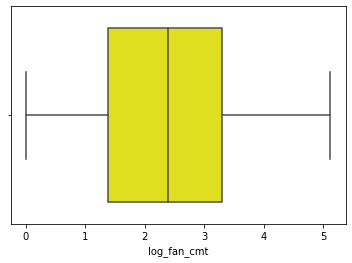

In [426]:
sns.boxplot(b1.log_fan_cmt, color='yellow')

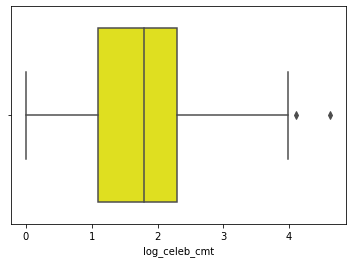

In [427]:
sns.boxplot(b1.log_celeb_cmt, color='yellow')

In [447]:
#평균 +- 2표쥰편차 이상치 제거
upper_outlier = b1.log_celeb_cmt.mean()+2*b1.log_celeb_cmt.std()
lower_outlier = b1.log_celeb_cmt.mean()-2*b1.log_celeb_cmt.std()

print(upper_outlier)
print(lower_outlier)

3.650871868194449
-0.30376875940874926


In [496]:
upper_outlier1 = b1.log_fan_cmt.mean()+1.5*b1.log_fan_cmt.std()
lower_outlier1 = b1.log_fan_cmt.mean()-1.5*b1.log_fan_cmt.std()

print(upper_outlier1)
print(lower_outlier1)

4.059212041564906
0.6687598718168077


In [455]:
b1_2std=b1[(upper_outlier>b1.log_celeb_cmt)&(lower_outlier<b1.log_celeb_cmt)]

In [497]:
b1_2std = b1[(upper_outlier1>b1.log_celeb_cmt)&(lower_outlier1<b1.log_celeb_cmt)]

#로그변환
- 독립변수와 종속변수 모두 데이터의 분포가 편향되어있음(right skewed)
- np.log1p()를 이용하여 로그변환  
값이 0인 경우가 있어 np.log() 대신 np.log1p()사용
- 	$\log{y_i}=α+β\log{x_i}+εi$

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

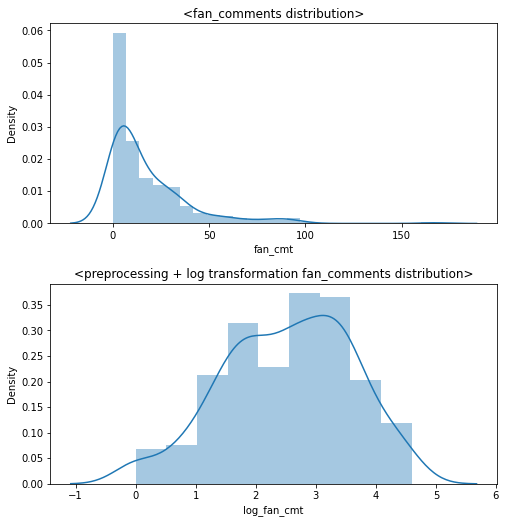

In [492]:
#팬 대화 수 분포
plt.figure(figsize=(8,8))
plt.subplot(211)
sns.distplot(b1['fan_cmt'])
plt.title("<fan_comments distribution>")
plt.subplot(212)
sns.distplot(b1_2std['log_fan_cmt'])
plt.title("<preprocessing + log transformation fan_comments distribution>")

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)

plt.show()

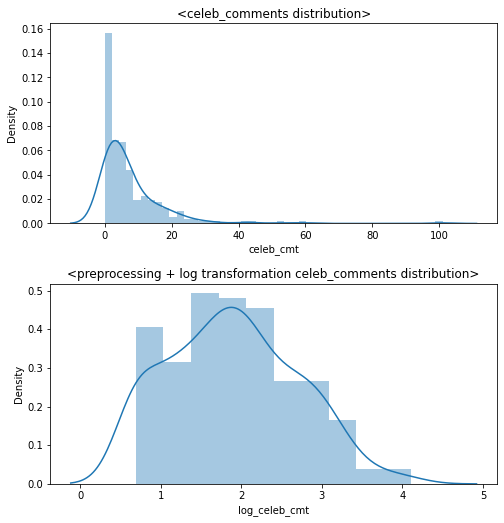

In [495]:
#셀럽 대화 수 분포
plt.figure(figsize=(8,8))
plt.subplot(211)
sns.distplot(b1['celeb_cmt'])
plt.title("<celeb_comments distribution>")
plt.subplot(212)
sns.distplot(b1_2std['log_celeb_cmt'])
plt.title("<preprocessing + log transformation celeb_comments distribution>")

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)

plt.show()

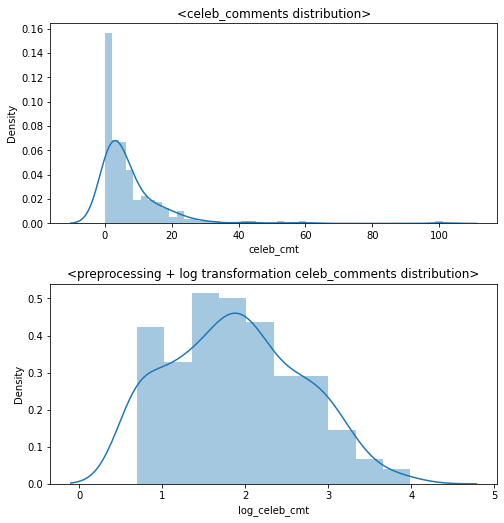

In [499]:
plt.figure(figsize=(8,8))
plt.subplot(211)
sns.distplot(b1['celeb_cmt'])
plt.title("<celeb_comments distribution>")
plt.subplot(212)
sns.distplot(b1_2std['log_celeb_cmt'])
plt.title("<preprocessing + log transformation celeb_comments distribution>")

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)

plt.show()

#회귀직선 시각화(VAYA 제거)

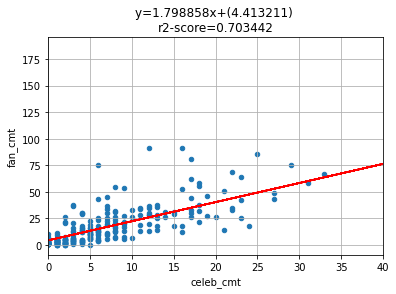

In [43]:
b1.plot(kind='scatter', x='celeb_cmt', y='fan_cmt')
fit_weight = np.polyfit(b1['celeb_cmt'], b1['fan_cmt'], 1) # 'celeb_cmt' 컬럼을 x값으로, fan_cmt 컬럼을 y값으로 하여 1차식으로 피팅한다.
trend_f = np.poly1d(fit_weight)
r2 = r2_score(b1['fan_cmt'], trend_f(b1['celeb_cmt']))
              
plt.plot(b1['celeb_cmt'], trend_f(b1['celeb_cmt']),"r-")
plt.title("y={:.6f}x+({:.6f}) \nr2-score={:.6f}".format(fit_weight[0], fit_weight[1], r2))
plt.grid(True)
plt.xlim([0, 40])
plt.show()

- 데이터의 분포가 극단에 치우쳐 있어서 회귀모델에 영향을 줄 수 있기 때문에 로그변환 시도 

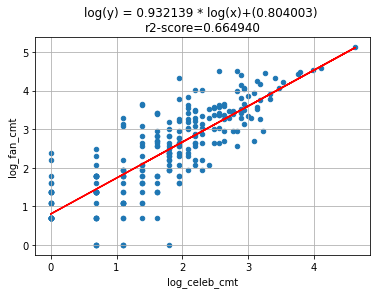

In [422]:
import numpy as np
b1.plot(kind='scatter', x='log_celeb_cmt', y='log_fan_cmt')
fit_weight = np.polyfit(b1['log_celeb_cmt'], b1['log_fan_cmt'], 1) # 'log_celeb_cmt' 컬럼을 x값으로, log_fan_cmt 컬럼을 y값으로 하여 1차식으로 피팅한다.
trend_f = np.poly1d(fit_weight)
r2 = r2_score(b1['log_fan_cmt'], trend_f(b1['log_celeb_cmt']))
              
plt.plot(b1['log_celeb_cmt'], trend_f(b1['log_celeb_cmt']),"r-")
plt.title("log(y) = {:.6f} * log(x)+({:.6f}) \nr2-score={:.6f}".format(fit_weight[0], fit_weight[1], r2))
plt.grid(True)
plt.show()

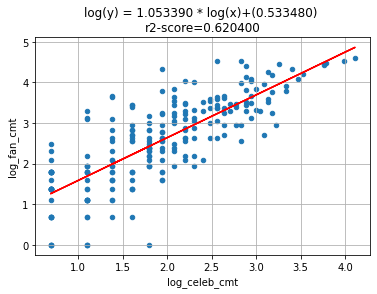

In [464]:
b1_2std.plot(kind='scatter', x='log_celeb_cmt', y='log_fan_cmt')
fit_weight = np.polyfit(b1_2std['log_celeb_cmt'], b1_2std['log_fan_cmt'], 1) # 'log_celeb_cmt' 컬럼을 x값으로, log_fan_cmt 컬럼을 y값으로 하여 1차식으로 피팅한다.
trend_f = np.poly1d(fit_weight)
r2 = r2_score(b1_2std['log_fan_cmt'], trend_f(b1_2std['log_celeb_cmt']))
              
plt.plot(b1_2std['log_celeb_cmt'], trend_f(b1_2std['log_celeb_cmt']),"r-")
plt.title("log(y) = {:.6f} * log(x)+({:.6f}) \nr2-score={:.6f}".format(fit_weight[0], fit_weight[1], r2))
plt.grid(True)
plt.show()

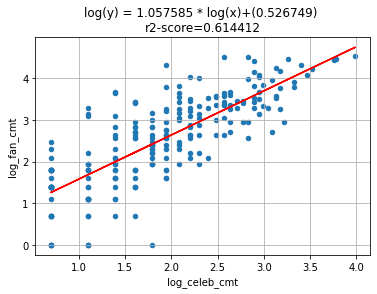

In [530]:
b1_2std.plot(kind='scatter', x='log_celeb_cmt', y='log_fan_cmt')
fit_weight = np.polyfit(b1_2std['log_celeb_cmt'], b1_2std['log_fan_cmt'], 1) # 'log_celeb_cmt' 컬럼을 x값으로, log_fan_cmt 컬럼을 y값으로 하여 1차식으로 피팅한다.
trend_f = np.poly1d(fit_weight)
r2 = r2_score(b1_2std['log_fan_cmt'], trend_f(b1_2std['log_celeb_cmt']))
              
plt.plot(b1_2std['log_celeb_cmt'], trend_f(b1_2std['log_celeb_cmt']),"r-")
plt.title("log(y) = {:.6f} * log(x)+({:.6f}) \nr2-score={:.6f}".format(fit_weight[0], fit_weight[1], r2))
plt.grid(True)
plt.show()

#ANOVA

In [232]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

In [360]:
model = smf.ols(formula = 'log_fan_cmt ~ log_celeb_cmt', data = b1)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_fan_cmt   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     520.0
Date:                Fri, 14 Jan 2022   Prob (F-statistic):           3.73e-64
Time:                        18:54:05   Log-Likelihood:                -262.06
No. Observations:                 264   AIC:                             528.1
Df Residuals:                     262   BIC:                             535.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8040      0.079     10.123      0.000       0.648       0.960
log_celeb_cmt     0.9321      0.041     22.802      0.000       0.852       1.013
==============================================================================
Omnibus:                        9.964   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               12.828
Skew:                          -0.304   Prob(JB):                      0.00164
Kurtosis:                       3.893   Cond. No.                         4.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- $r^2$-score : 0.665 , 회귀선에의해 데이터 약 66.5% 설명됨

- $H_0$: 회귀모형이 유의하지 않다  
  $H_1$: 회귀모형이 유의하다.  
 회귀모형의 F값이 520.0이고 유의확률(Pr>F)은 0.000으로 유의수준  0.05보다 작다. 통계적으로 유의한 모형  

- 회귀식 절편의 t값이 10.123이고 유의확률(P>|t|)은 0.000으로 회귀모형의 절편값은 유의하고 값은 0.804  

- 셀럽의 대화 수(x)의 t값이 22.802이고 유의확률유의확률(P>|t|)은 0.000으로 회귀모형의 계수는 유의하고 값은 0.9321  

- $\log{y_i}=0.9321\log{x_i}+0.804$  
셀럽의 대화(x)가 1% 증가할수록 팬의 대화가 0.9321% 증가
  
- $H_0$: 잔차들 사이에 자기상관관계가 없다.(독립이다)   
  $H_1$: 잔차들 사이에 자기상관관계가 있다.  
  Durbin-Watson값이 2.010으로 귀무가설을 기각할수 없다.
  따라서 잔차들이 서로 독립적이라고 할 수 있다.
  잔차들이 서로 독립이므로 회귀모형이 적합하다고 할 수 있다.

In [465]:
model = smf.ols(formula = 'log_fan_cmt ~ log_celeb_cmt', data = b1_2std)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_fan_cmt   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     374.3
Date:                Fri, 14 Jan 2022   Prob (F-statistic):           4.54e-50
Time:                        22:44:36   Log-Likelihood:                -231.36
No. Observations:                 231   AIC:                             466.7
Df Residuals:                     229   BIC:                             473.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5335      0.112      4.769      0.000       0.313       0.754
log_celeb_cmt     1.0534      0.054     19.346      0.000       0.946       1.161
==============================================================================
Omnibus:                        4.793   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                5.665
Skew:                          -0.152   Prob(JB):                       0.0589
Kurtosis:                       3.705   Cond. No.                         6.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- $r^2$-score : 0.620 , 회귀선에의해 데이터 약 62.0% 설명됨

- $H_0$: 회귀모형이 유의하지 않다  
  $H_1$: 회귀모형이 유의하다.  
 회귀모형의 F값이 374.3이고 유의확률(Pr>F)은 0.000으로 유의수준  0.05보다 작다. 통계적으로 유의한 모형  

- 회귀식 절편의 t값이 10.123이고 유의확률(P>|t|)은 0.000으로 회귀모형의 절편값은 유의하고 값은 0.5335  

- 셀럽의 대화 수(x)의 t값이 22.802이고 유의확률유의확률(P>|t|)은 0.000으로 회귀모형의 계수는 유의하고 값은 1.0534  

- $\log{y_i}=1.0534\log{x_i}+0.5335$  
셀럽의 대화(x)가 1% 증가할수록 팬의 대화가 1.0534% 증가
  
- $H_0$: 잔차들 사이에 자기상관관계가 없다.(독립이다)   
  $H_1$: 잔차들 사이에 자기상관관계가 있다.  
  Durbin-Watson값이 2.050으로 귀무가설을 기각할수 없다.
  따라서 잔차들이 서로 독립적이라고 할 수 있다.
  잔차들이 서로 독립이므로 회귀모형이 적합하다고 할 수 있다.

#잔차분석(log변환 - VAYA제거)

In [385]:
res = ols('log_fan_cmt ~ log_celeb_cmt', data = b1).fit()

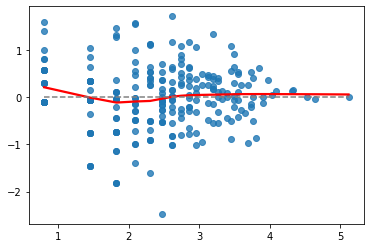

In [388]:
fitted = res.predict(b1)
residual = b1['log_fan_cmt'] - fitted

sns.regplot(fitted, residual, lowess=True, line_kws={'color':'red'})
plt.plot([fitted.min(),fitted.max()], [0,0], '--', color='grey')
plt.show()

- 잔차의 추세선(빨간 선)이 예측값(회색 점선)과 크게 다르지 않으므로 회귀모형이 선형성을 만족

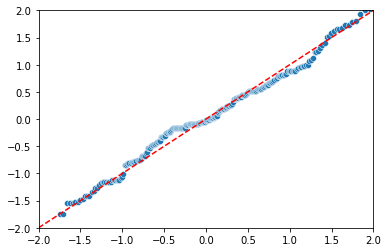

In [397]:
import scipy.stats
sr = scipy.stats.zscore(residual)
(x,y),_ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-2,2],[-2,2],'--', color='red')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

- 실제 데이터(파란 점)가 대체적으로 Q-Q plot의 선 위에 존재하므로 정규성을 만족한다.

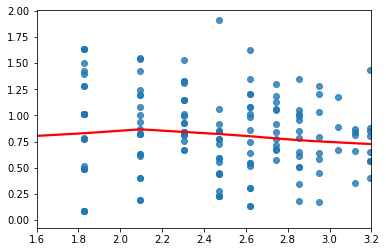

In [476]:
import numpy as np
sns.regplot(fitted, np.sqrt(np.abs(sr)), lowess=True,line_kws={'color':'red'})
plt.xlim([1.6,3.2])
plt.show()

- 예측값(x축)에 따라 잔차(y)의 추세 변화선이 수평과 비슷하게 형성되므로 등분산성을 만족한다.

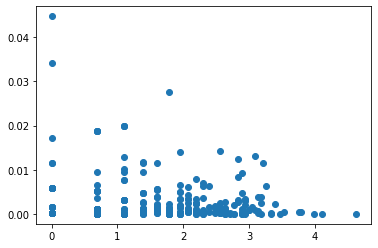

In [412]:
np.set_printoptions(suppress=True)
influence = cookmodel.get_influence()
cooks = influence.cooks_distance

plt.scatter(b1.log_celeb_cmt,cooks[0])
plt.show()

In [466]:
res = ols('log_fan_cmt ~ log_celeb_cmt', data = b1_2std).fit()

In [502]:
import scipy.stats as stats

#상관분석

In [505]:
stats.pearsonr(b1_2std['log_celeb_cmt'],b1_2std['log_fan_cmt'])

(0.7838446414677261, 4.4168765101298494e-49)

- p-value < 0.05이므로 두 변수는 상관관계가 있다.

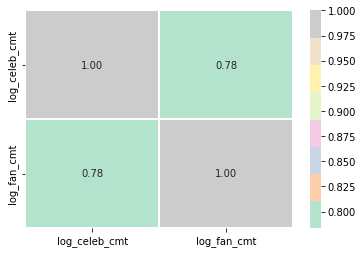

In [515]:
sns.heatmap(b1_2std[['log_celeb_cmt', 'log_fan_cmt']].corr(), annot=True, fmt='.2f',linewidths=.5, cmap='Pastel2')

- pearson 상관계수 0.78로 '셀럽의 대화 수'와 '팬의 대화 수'는 매우 강한 양의 상관관계를 가진다.

In [519]:
df.label.value_counts()

1    8001
2    2229
0      67
Name: label, dtype: int64

In [518]:
df_new.label.value_counts()

1    6650
2     567
0      39
Name: label, dtype: int64